In [1]:
%autosave 0
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
import statistics

import xgboost

from alys import regression as ALYR
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


# Contexte

In [2]:
mod_full = False # Active le fichier de scrap si on passe sur True = le fichier de scrap + celui traité par Aro sur gouv
look_for_opti = False # Active gridsearch

In [3]:
if mod_full:
    df = pd.read_csv('Base_Files/house_full.csv', index_col =0)
else :    
    df = pd.read_csv('Base_Files/house_ligth.csv', index_col =0)

# Visualisation des données

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3505 entries, 0 to 3504
Data columns (total 7 columns):
id              3505 non-null int64
type_de_bien    3505 non-null object
année           1687 non-null float64
nb_de_pieces    3505 non-null int64
surface         3505 non-null int64
ville           3505 non-null object
prix            3505 non-null int64
dtypes: float64(1), int64(4), object(2)
memory usage: 219.1+ KB


In [5]:
def null_values(df):
    
    sum_null = df.isnull().sum()
    total = df.isnull().count()
    percent_nullvalues = 100* sum_null / total 
    df_null = pd.DataFrame()
    df_null['Total'] = total
    df_null['Null_Count'] = sum_null
    df_null['Percent'] = round(percent_nullvalues,2)
    df_null = df_null.sort_values(by='Null_Count',ascending = False)
    df_null = df_null[df_null.Null_Count > 0]
    
    return(df_null)

null_values(df)

,Total,Null_Count,Percent
année,3505,1818,51.87


In [6]:
df = df.drop(['id','année'], axis=1)

In [7]:
df['ville'] = df['ville'].str.strip() #Correction du premier charactère == " ".

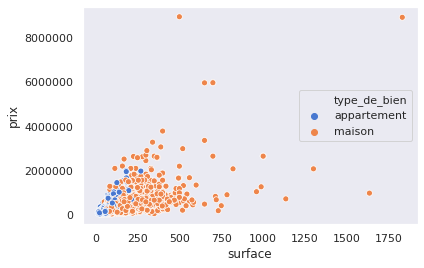

In [8]:
sns.set(style="dark", palette="muted", font='DejaVu Sans', font_scale=1, color_codes=True)
sns.scatterplot(x="surface", y="prix", hue="type_de_bien", data=df)

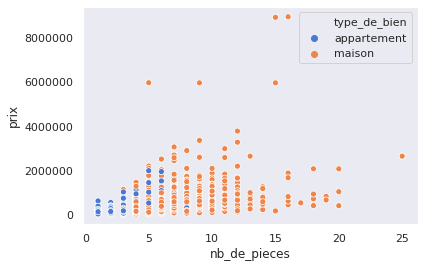

In [9]:
sns.set(style="dark", palette="muted", font='DejaVu Sans', font_scale=1, color_codes=True)
sns.scatterplot(x="nb_de_pieces", y="prix", hue="type_de_bien", data=df)

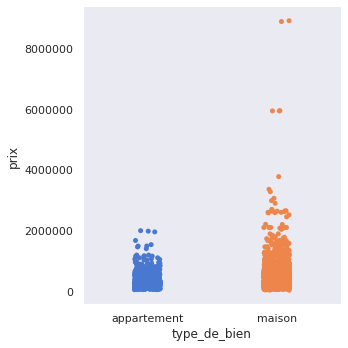

In [10]:
sns.catplot(x='type_de_bien',y='prix',data=df ,hue='type_de_bien')

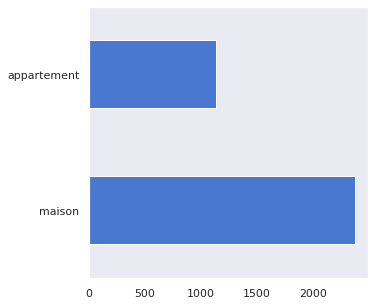

In [11]:
df['type_de_bien'].value_counts().head(2).plot(kind='barh', figsize=(5,5))

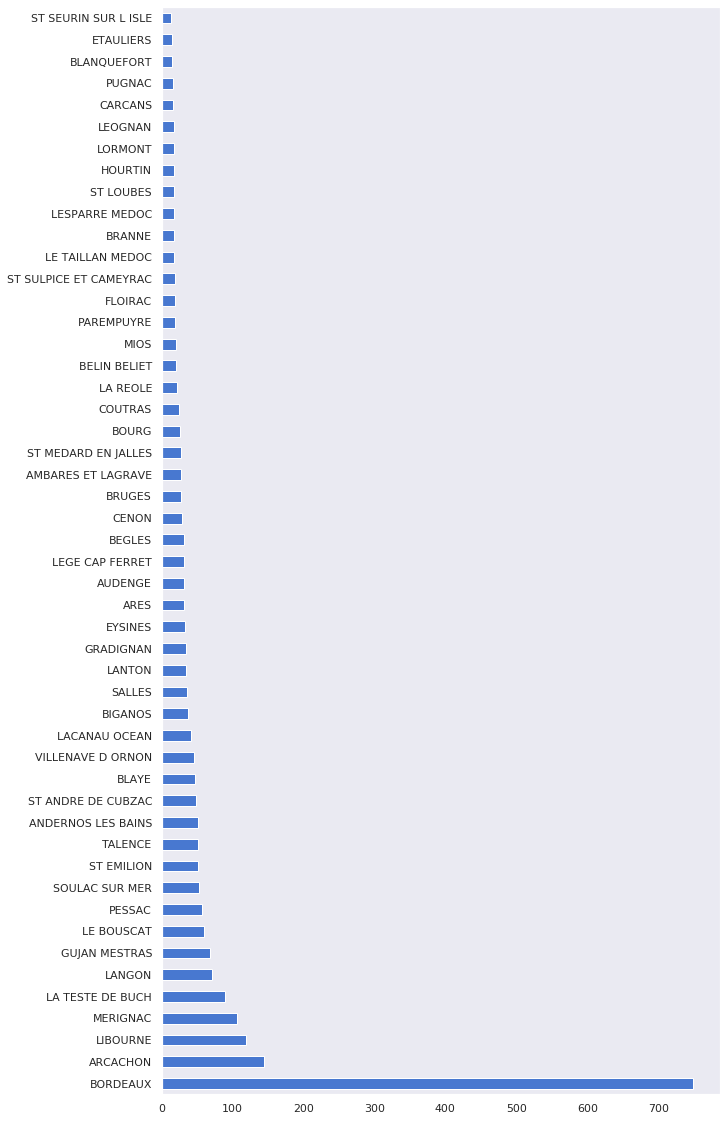

In [12]:
df['ville'].value_counts().head(50).plot(kind='barh', figsize=(10,20))

# Features engineering

In [13]:
# sclol = df[df['ville'].isin(["LIBOURNE"])]

In [14]:
# x = df.groupby('ville').agg(['count'])

# count=0
# vill_mal_rep = []

# for ele in x['prix', 'count'] :
#     if ele < 3 :
#         vill_mal_rep.append(x.index[count])
#     count += 1 
    
# # Liste des villes représentées 1 ou 2 fois dans le df     
# vill_mal_rep

In [15]:
count = 0
for i in df["ville"]:
    df.loc[count,"p_m2"] = df.loc[count,"prix"]/df.loc[count,"surface"]
    count +=1

In [16]:
# count = 0
# for vi in df["ville"]:
#     scbuild = df[df['ville'].isin([f"{vi}"])]
#     k_5 = statistics.mean(scbuild["p_m2"])
#     Q1 = min(scbuild["p_m2"])
#     df.loc[count,"Q1_pm2"] = Q1
#     df.loc[count,"Q2_pm2"] = ((k_5+Q1)/2)
#     df.loc[count,"Q3_pm2"] = k_5
#     Q5 =  max(scbuild["p_m2"])
#     df.loc[count,"Q5_pm2"] = Q5
#     df.loc[count,"Q4_pm2"] = ((k_5+Q5)/2)
#     count +=1

# Suppression des outliers

A l'aide des visualisations, je fais le lien avec les index a drop

In [17]:
df.sort_values("prix", axis = 0, ascending = False).head(10)

,type_de_bien,nb_de_pieces,surface,ville,prix,p_m2
2842,maison,16,500,BORDEAUX,8925000,17850.000000
3167,maison,15,1830,BORDEAUX,8900000,4863.387978
3024,maison,5,700,ARCACHON,5956500,8509.285714
1215,maison,9,700,ARCACHON,5950000,8500.000000
2070,maison,15,650,ARCACHON,5950000,9153.846154
3285,maison,12,400,BORDEAUX,3780000,9450.000000
2579,maison,9,650,BORDEAUX,3360000,5169.230769
344,maison,12,340,ARCACHON,3280000,9647.058824
3159,maison,7,389,ARCACHON,3065000,7879.177378
1761,maison,11,520,LE BOUSCAT,2987000,5744.230769


In [18]:
df.sort_values("p_m2", axis = 0, ascending = False).head(10)

,type_de_bien,nb_de_pieces,surface,ville,prix,p_m2
1320,maison,5,115,ANDERNOS LES BAINS,2100000,18260.869565
2842,maison,16,500,BORDEAUX,8925000,17850.000000
3187,maison,4,85,LEGE CAP FERRET,1294710,15231.882353
2972,maison,6,170,CAP FERRET,2520000,14823.529412
537,maison,5,160,ARCACHON,2205000,13781.250000
2368,maison,3,85,LEGE CAP FERRET,1152250,13555.882353
1523,appartement,2,28,ARCACHON,368000,13142.857143
36,appartement,2,40,ARCACHON,525000,13125.000000
1781,appartement,3,71,ARCACHON,892500,12570.422535
1263,appartement,2,45,ARCACHON,565000,12555.555556


In [19]:
df.sort_values("surface", axis = 0, ascending = False).head(10)

,type_de_bien,nb_de_pieces,surface,ville,prix,p_m2
3167,maison,15,1830,BORDEAUX,8900000,4863.387978
1956,maison,8,1634,SALLES,987000,604.039168
3277,maison,20,1300,CASSEUIL,2080000,1600.000000
1378,maison,5,1135,LACANAU OCEAN,728000,641.409692
3313,maison,25,1000,BORDEAUX,2650000,2650.000000
2091,maison,25,1000,BORDEAUX,2650000,2650.000000
2090,maison,25,1000,BLAYE,2650000,2650.000000
1319,maison,14,988,ARVEYRES,1272000,1287.449393
2323,maison,20,960,BORDEAUX,1050000,1093.750000
1885,maison,18,820,BORDEAUX,2080000,2536.585366


In [20]:
df.sort_values("nb_de_pieces", axis = 0, ascending = False).head(10)

,type_de_bien,nb_de_pieces,surface,ville,prix,p_m2
2091,maison,25,1000,BORDEAUX,2650000,2650.000000
2090,maison,25,1000,BLAYE,2650000,2650.000000
3313,maison,25,1000,BORDEAUX,2650000,2650.000000
2323,maison,20,960,BORDEAUX,1050000,1093.750000
2205,maison,20,540,PUGNAC,420000,777.777778
3277,maison,20,1300,CASSEUIL,2080000,1600.000000
2204,maison,20,540,ST CHRISTOLY DE BLAYE,420000,777.777778
2975,maison,19,575,LIBOURNE,680000,1182.608696
2399,maison,19,715,BORDEAUX,840000,1174.825175
2398,maison,18,400,LIBOURNE,945000,2362.500000


In [21]:
df.sort_values("prix", axis = 0, ascending = True).head(10)

,type_de_bien,nb_de_pieces,surface,ville,prix,p_m2
2453,maison,3,40,RAUZAN,28500,712.500000
1813,maison,3,68,RAUZAN,38500,566.176471
3311,maison,2,41,VILLENEUVE,40000,975.609756
258,maison,3,87,ST YZANS DE MEDOC,40000,459.770115
230,maison,2,30,AUROS,45000,1500.000000
2356,appartement,2,36,BLAYE,48000,1333.333333
1739,appartement,2,50,CARTELEGUE,48000,960.000000
3270,maison,4,97,STE FOY LA GRANDE,49000,505.154639
3488,appartement,1,25,GIRONDE SUR DROPT,50000,2000.000000
3489,appartement,1,25,GIRONDE SUR DROPT,50000,2000.000000


In [22]:
# -- Outliers général -- 1155, 1337,1215,269,518,517 ,2204 ,2205,2842,2902,3024,1956

df = df.drop([df.index[1155] , df.index[1337], df.index[1215],
              df.index[269],df.index[518] ,df.index[517],
              df.index[2204] , df.index[2205], df.index[2842],
              df.index[2902],df.index[3024] ,df.index[1956]])

In [23]:
df.shape

(3493, 6)

# Preprocessing, Split et création de Pipeline

In [24]:
df['PriceLog'] = np.log(df.prix)

In [25]:
corr = df.corr().abs()
corr.prix[corr.prix >= 0].sort_values(ascending=False)

prix            1.000000
PriceLog        0.819907
surface         0.598269
nb_de_pieces    0.503994
p_m2            0.427028
Name: prix, dtype: float64

In [26]:
y_full = df['PriceLog'].values

x_full = df.drop(['prix','PriceLog'], axis=1)
x_full.shape,y_full.shape

((3493, 5), (3493,))

In [27]:
categoricals = ['type_de_bien', 'ville']

In [28]:
categorical_pipe = Pipeline([
    ('oe', OneHotEncoder(handle_unknown="ignore"))
])

In [29]:
poly = ['nb_de_pieces', 'surface',"p_m2"]

In [30]:
poly_pipe = Pipeline([
    ("poly", PolynomialFeatures(2))
])

In [31]:
scale_pipe = Pipeline([
    ('scaler', StandardScaler())
])

In [32]:
preprocess_pipe = ColumnTransformer([
    ("enc", categorical_pipe, categoricals),
    ("sca", scale_pipe, poly),
    ("pol", poly_pipe , poly),
])

In [33]:
xgb = xgboost.XGBRegressor(colsample_bytree=0.5, subsample=0.7,
                             learning_rate=0.05, max_depth=5, 
                             min_child_weight=1.8, n_estimators=1000,
                             reg_alpha=0.1, reg_lambda=0.3, gamma=0.01, 
                             silent=1, random_state =7, nthread = -1)

In [34]:
seed = 60
np.random.seed(seed)

In [35]:
x_train, x_val, y_train, y_val = train_test_split(x_full,y_full , test_size=0.1, random_state=seed)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((3143, 5), (350, 5), (3143,), (350,))

In [36]:
model = Pipeline([
    ('pre', preprocess_pipe),
    ('reg', xgb)
])

# Entrainement du modèle

In [37]:
model.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'pre', 'reg', 'pre__n_jobs', 'pre__remainder', 'pre__sparse_threshold', 'pre__transformer_weights', 'pre__transformers', 'pre__verbose', 'pre__enc', 'pre__sca', 'pre__pol', 'pre__enc__memory', 'pre__enc__steps', 'pre__enc__verbose', 'pre__enc__oe', 'pre__enc__oe__categories', 'pre__enc__oe__drop', 'pre__enc__oe__dtype', 'pre__enc__oe__handle_unknown', 'pre__enc__oe__sparse', 'pre__sca__memory', 'pre__sca__steps', 'pre__sca__verbose', 'pre__sca__scaler', 'pre__sca__scaler__copy', 'pre__sca__scaler__with_mean', 'pre__sca__scaler__with_std', 'pre__pol__memory', 'pre__pol__steps', 'pre__pol__verbose', 'pre__pol__poly', 'pre__pol__poly__degree', 'pre__pol__poly__include_bias', 'pre__pol__poly__interaction_only', 'pre__pol__poly__order', 'reg__base_score', 'reg__booster', 'reg__colsample_bylevel', 'reg__colsample_bynode', 'reg__colsample_bytree', 'reg__gamma', 'reg__importance_type', 'reg__learning_rate', 'reg__max_delta_step', 'reg__max_depth', 'reg_

In [38]:
if look_for_opti : 
    param_grid = [{
        'reg__n_estimators': [800,900,1000,1200],'reg__max_depth': [4,5,6,7]
    }]

    my_learn = model
    grid_search = GridSearchCV(my_learn,param_grid, cv=5, scoring ='neg_mean_squared_error', return_train_score=True)
    grid_search.fit(x_train,y_train)

if look_for_opti : 
    grid_search.best_params_

In [39]:
model.fit(x_train,y_train);

# Evaluation du modèle avec le fichier de train

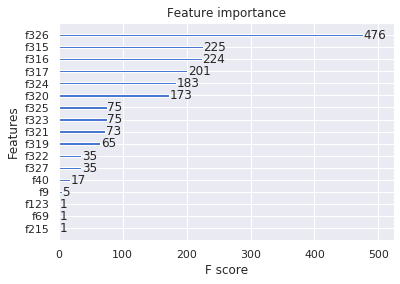

In [40]:
xgboost.plot_importance(xgb,max_num_features=20)

In [41]:
y_valid_pred = model.predict(x_train)

RMSE :  29110.9892
MAE :  6774.9093


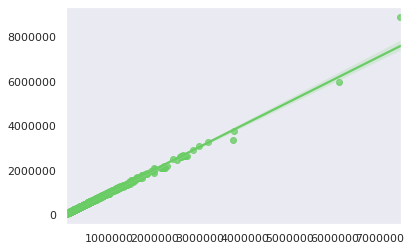

In [42]:

xgb_pred_ref = np.exp(y_valid_pred)

y_val_rescale = y_train.reshape(y_train.shape[0])
y_val_rescale = np.exp(y_val_rescale)

RMSE = np.sqrt(MSE(xgb_pred_ref, y_val_rescale))
print('RMSE : ', RMSE.round(4))

score = MAE(xgb_pred_ref, y_val_rescale)
print('MAE : ', round(score,4))

sns.regplot(xgb_pred_ref, y_val_rescale, color="g")

# Evaluation du modèle avec le fichier de validation

In [43]:
y_valid_pred = model.predict(x_val)

RMSE :  12025.5743
MAE :  6968.3053


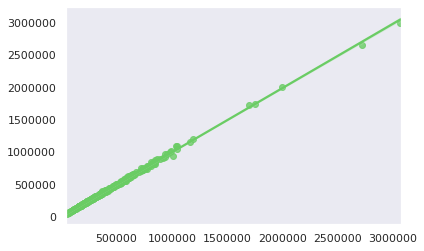

In [44]:
xgb_pred_ref = np.exp(y_valid_pred)

y_val_rescale = y_val.reshape(y_val.shape[0])
y_val_rescale = np.exp(y_val_rescale)

RMSE = np.sqrt(MSE(xgb_pred_ref, y_val_rescale))
print('RMSE : ', RMSE.round(4))

score = MAE(xgb_pred_ref, y_val_rescale)
print('MAE : ', round(score,4))

sns.regplot(xgb_pred_ref, y_val_rescale, color="g")

In [45]:
visu = pd.DataFrame()
visu["val_price"] = y_val_rescale
visu["Prediction"] = xgb_pred_ref
visu["Prediction"] = round(visu["Prediction"])


ALYR.regr(visu)
ALYR.posneg(visu)

######### saisir Prediction puis val_price ###############

nom colonne prediction : Prediction
nom colonne output : val_price
MAPE =  1.73
On a 183 erreurs positive, 167 erreurs negative, 0 prediction parfaite


,val_price,Prediction,pourcerror,errorabs,mape,RMSE,positive erreur,negatif erreur,prediction parfaite
0,313000.0,315457.0,0.007850,0.01,1.73,12025.562573,183.0,167.0,0.0
1,254000.0,262960.0,0.035276,0.04,NaN,NaN,NaN,NaN,NaN
2,242000.0,236107.0,-0.024351,0.02,NaN,NaN,NaN,NaN,NaN
3,840000.0,841251.0,0.001489,0.00,NaN,NaN,NaN,NaN,NaN
4,318000.0,311002.0,-0.022006,0.02,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
345,335000.0,330923.0,-0.012170,0.01,NaN,NaN,NaN,NaN,NaN
346,75000.0,76248.0,0.016640,0.02,NaN,NaN,NaN,NaN,NaN
347,389200.0,398152.0,0.023001,0.02,NaN,NaN,NaN,NaN,NaN
348,213000.0,208981.0,-0.018869,0.02,NaN,NaN,NaN,NaN,NaN


In [46]:
visu.sort_values("errorabs", axis = 0, ascending = False).head(20)

,val_price,Prediction,pourcerror,errorabs,mape,RMSE,positive erreur,negatif erreur,prediction parfaite
258,48000.0,52304.0,0.089667,0.09,NaN,NaN,NaN,NaN,NaN
77,399000.0,367399.0,-0.079201,0.08,NaN,NaN,NaN,NaN,NaN
105,298000.0,274472.0,-0.078953,0.08,NaN,NaN,NaN,NaN,NaN
80,125000.0,134163.0,0.073304,0.07,NaN,NaN,NaN,NaN,NaN
307,945000.0,1007325.0,0.065952,0.07,NaN,NaN,NaN,NaN,NaN
70,635000.0,599157.0,-0.056446,0.06,NaN,NaN,NaN,NaN,NaN
91,1094640.0,1033228.0,-0.056102,0.06,NaN,NaN,NaN,NaN,NaN
143,168000.0,177808.0,0.058381,0.06,NaN,NaN,NaN,NaN,NaN
287,420000.0,396020.0,-0.057095,0.06,NaN,NaN,NaN,NaN,NaN
309,154500.0,163472.0,0.058071,0.06,NaN,NaN,NaN,NaN,NaN


In [47]:
ALYR.seuil_vs_error(visu)

######## Choisir un seuil en float entre 0.0 et 1 ######################

valeur du seuil :0.2
il y'a 350 erreurs inférieurs à 0.2, il y'a 0 erreurs supérieurs à 0.2
erreur sous seuil = 100.0%


100.0

In [48]:
ALYR.seuil_vs_error(visu)

######## Choisir un seuil en float entre 0.0 et 1 ######################

valeur du seuil :0.1
il y'a 350 erreurs inférieurs à 0.1, il y'a 0 erreurs supérieurs à 0.1
erreur sous seuil = 100.0%


100.0

In [49]:
######## Dump du modèle, pensez a changer le numéro de version ######################

# dump(model, 'model_xgb_v3.joblib')

# Simulation en Production

In [50]:
def singlePrediction():
    k1 = str(input("Type de bien : maison ou appartement : "))
    k1 = k1.lower()
    k2 = int(input("Nombre de pièces dans le logement : "))
    
    k3 = int(input("Combien de métres carrés : "))
    k4 = str(input("Dans quelle ville : "))
    k4= k4.upper()
    
    
    sclol = df[df['ville'].isin([f"{k4}"])]
    if len(sclol) < 4 :
        niv_confidence = "Faible, l'Ia connait peut cette ville"
    elif len(sclol) >3 and len(sclol) <10 : 
        niv_confidence = "Normal, l'Ia connait cette ville, mais manque un peu d'information"
    elif len(sclol) >=10 : 
        niv_confidence = "Forte"
    
    if len(sclol) != 0 :
        k5 = statistics.mean(sclol["p_m2"])
    else :
        niv_confidence = "Faible, l'Ia connait pas cette ville"
        k5 = statistics.mean(df["p_m2"])
     
    x = pd.DataFrame()
    x.loc[0,"type_de_bien"] = f"{k1}"
    x.loc[0,"nb_de_pieces"] = f"{k2}"
    x.loc[0,"surface"] = f"{k3}"
    x.loc[0,"ville"] = f"{k4}"
    x.loc[0,"p_m2"] = f"{k5}"
    print("-------------")
    sing_pred = model.predict(x)
    sing_pred = np.exp(sing_pred)
    print("-------------")
    print(f"Confiance de la prediction : {niv_confidence}")
    print("Prix estimé ",int(sing_pred), "€")
    
    # sclol = df[df['ville'].isin(["BORDEAUX"])]
    # k5 = statistics.mean(sclol["p_m2"])

    # print("---------")

    # Q1 = min(sclol["p_m2"])
    # print(Q1)
    # Q2 = ((k5+Q1)/2)
    # print(Q2)
    # print("**********")
    # Q3 = k5
    # print(Q3)
    # print("**********")
    # Q5 = max(sclol["p_m2"])
    # Q4 = ((k5+Q5)/2)
    # print(Q4)
    # print(Q5)

    # etat = "Bon"

    # if etat == "Mauvais":
    #     k5 = Q1
    # elif etat == "Moyen":
    #     k5 = Q2
    # elif etat == "Normal":
    #     k5 = Q3
    # elif etat == "Bon":
    #     k5 = Q4
    # elif etat == "Excelent":
    #     k5 = Q5


    # print("^^^^^^^^^^")
    # print(k5)

In [51]:
singlePrediction()

Type de bien : maison ou appartement : appartement
Nombre de pièces dans le logement : 2
Combien de métres carrés : 35
Dans quelle ville : BORDEAUX
-------------
-------------
Confiance de la prediction : Forte
Prix estimé  172573 €


In [52]:
singlePrediction()

Type de bien : maison ou appartement : maison
Nombre de pièces dans le logement : 5
Combien de métres carrés : 100
Dans quelle ville : PORT STE FOY ET PONCHAPT
-------------
-------------
Confiance de la prediction : Faible, l'Ia connait peut cette ville
Prix estimé  89241 €


# Verification de la gestion des erreurs d'input utilisateur

In [53]:
singlePrediction()

Type de bien : maison ou appartement : je sais pas
Nombre de pièces dans le logement : 8
Combien de métres carrés : 739
Dans quelle ville : n importe ou en gironde
-------------
-------------
Confiance de la prediction : Faible, l'Ia connait pas cette ville
Prix estimé  2314587 €


# Evolution du Score du modèle en production

# --V1--

# --V2--

# --V3--